The loss function for the deadtime model Poisson point process is:

$$ L = \sum_{m=1}^{M}{[N_{shots}\lambda(t_m)\Delta t H_{m}^{(I)} - ln(\lambda(t_m)) H_{m}^{(P)}]} $$

Please refer to Matt Hayman's reference notes on this topic for a description of the terms. Basically $H_{m}^{(I)}$ is the histogram (normalized) of the active time of the detector (this is where the Poisson point process inherits the effect of deadtime). $H_{m}^{(P(}$ is the detection histogram.

Analytically minimizing the loss function per grid bin $m$ (assuming Riemann sum for $\Lambda$):

$$ \frac{dL}{d\lambda(t_m)} = 0 = N_{shots}\Delta t H_{m}^{(I)} - \frac{1}{\lambda(t_m)}H_{m}^{(P)} $$
$$ \lambda(t_m) =  \frac{H_{m}^{(P)}}{N_{shots}\Delta t H_{m}^{(I)}}$$

I'm doing this by treating each time bin essentially as its own independent detector. The result will be a noisy fit compared to the maximum likelihood gradient descent approach that constrains the entire function as a sum over the bins, but this can be analytically solved and should at least show an approximation of what the function should "generally" look like.

In [1]:
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import os, sys
import xarray as xr
import pandas as pd

cwd = os.getcwd()
dirLib = cwd + r'/../library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

from load_ARSENL_data import load_INPHAMIS_data, set_binwidth
import data_organize as dorg
import fit_polynomial_utils as fit

import matplotlib as mpl
mpl.rcParams.update({"figure.facecolor": "white"})

### First obtain $H_{m}^{(P)}$

In [2]:
# Constants
c = 299792458  # [m/s] Speed of light

# Parameters
create_csv = False  # Set TRUE to generate a .csv from .ARSENL data
load_data = True  # Set TRUE to load data into a DataFrame and serialize into a pickle object
window_bnd = [30e-9, 40e-9]  # [s] Set temporal boundaries for binning
dt = 25e-12  # [s] Resolution
deadtime = 29.1e-9  # [s]

data_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Data\SPCM_Data_2023.03.06/'
fname = r'\OD39_Dev_0_-_2023-03-06_14.23.19_OD3.9.ARSENL.nc'
OD = float(fname[3:5])/10

max_lsr_num = int(1e5)
exclude_shots = True

In [3]:
ds = xr.open_dataset(data_dir + fname)

t_min = window_bnd[0]
t_max = window_bnd[1]

cnts = ds.time_tag
flight_time = cnts * dt  # [s]
# Exclude specified t.o.f. bins
flight_time = flight_time[np.where((flight_time >= window_bnd[0]) & (flight_time < window_bnd[1]))]

n_shots = len(ds.sync_index)

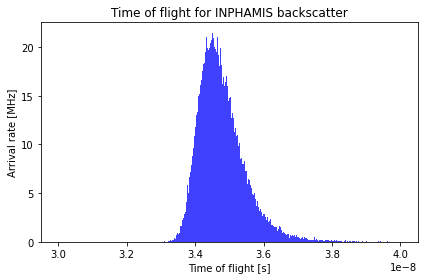

In [4]:
### Histogram of time of flight ###
fig = plt.figure()
ax1 = fig.add_subplot(111)
bin_array = set_binwidth(t_min, t_max, dt)
n, bins = np.histogram(flight_time, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots
center = 0.5 * (bins[:-1]+bins[1:])
ax1.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.75)
ax1.set_xlabel('Time of flight [s]')
ax1.set_ylabel('Arrival rate [MHz]')
ax1.set_title('Time of flight for INPHAMIS backscatter')
plt.tight_layout()
plt.show()

In [5]:
H_P = n

### Next obtain $H_{m}^{(I)}$

In [6]:
intgrl_N = len(n)

In [7]:
flight_time, n_shots, t_det_lst = dorg.data_organize(dt, data_dir, fname, window_bnd, max_lsr_num,
                                                                 exclude_shots)

active_ratio_hst_ref = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)

Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100005)...


In [8]:
H_I = active_ratio_hst_ref

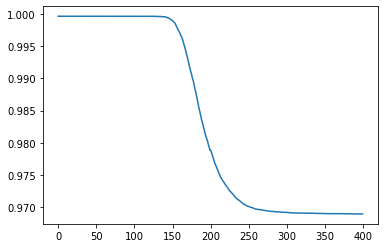

In [9]:
plt.plot(active_ratio_hst_ref)
plt.show()

### Now generate analytic solution to minimized loss function

In [10]:
lamb = H_P/H_I/dt/n_shots  # [Hz]

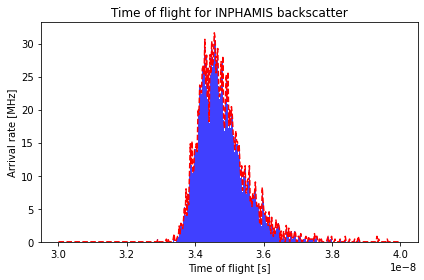

In [11]:
### Histogram of time of flight ###
fig = plt.figure()
ax1 = fig.add_subplot(111)
bin_array = set_binwidth(t_min, t_max, dt)
n, bins = np.histogram(flight_time, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots
center = 0.5 * (bins[:-1]+bins[1:])
ax1.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.75)
ax1.plot(center, N/H_I/1e6, 'r--')
ax1.set_xlabel('Time of flight [s]')
ax1.set_ylabel('Arrival rate [MHz]')
ax1.set_title('Time of flight for INPHAMIS backscatter')
plt.tight_layout()

save_loc = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Figures\scale_bins_deadtime_03.06.23_data'
save_name = r'\OD{}.png'.format(OD)
plt.savefig(save_loc+save_name)
plt.show()

### To automate this, loop over all the files.

In [24]:
files = []
OD_lst = []
for file in os.listdir(data_dir):
    if file.endswith(".ARSENL.nc"):
        files.append(file)
        OD_lst.append(float(file[2:4])/10)

In [25]:
save_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss'
save_csv_file = r'\active_ratio_hist_{}{:.1E}-{:.1E}_shots{:.2E}_best_fit.csv'.format('OD', OD_lst[0], OD_lst[-1],  n_shots)

In [18]:
H_I_lst = []
t_min = window_bnd[0]
t_max = window_bnd[1]

start = time.time()
for i in range(len(files)):
    fname = files[i]
    ds = xr.open_dataset(os.path.join(data_dir, fname))

    cnts = ds.time_tag
    flight_time = cnts * dt  # [s]
    # Exclude specified t.o.f. bins
    flight_time = flight_time[np.where((flight_time >= window_bnd[0]) & (flight_time < window_bnd[1]))]

    n_shots = len(ds.sync_index)
    
    H_P = n
    
    intgrl_N = len(n)
    flight_time, n_shots, t_det_lst = dorg.data_organize(dt, data_dir, fname, window_bnd, max_lsr_num, exclude_shots)
    active_ratio_hst_ref = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)
    
    H_I = active_ratio_hst_ref.numpy()
    
    H_I_lst.append(H_I)
    
print('Time elapsed: {:.2f} s'.format(time.time()-start))

Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100001)...
Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100001)...
Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100002)...
Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100005)...
Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100003)...
Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100008)...
Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100004)...
Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 100005)...
Last sync event doesn't correspond to a detection event.

In [19]:
np.shape(np.array(H_I_lst).T.tolist())

(400, 33)

In [20]:
headers = ['OD'+str(i) for i in OD_lst]
df_out = pd.DataFrame(np.array(H_I_lst).T.tolist())
df_out = df_out.to_csv(save_dir + save_csv_file, header=headers)

### Overlay scaling with the fit

In [33]:
load_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Manuscripts\Deadtime Model Paper\Data\termination_relstep_1e-7_nshots_1e5'
fname_dead_fit = r'\eval_loss_dtimeTrue_OD1.5E+00-5.0E+00_order7-23_shots1.00E+05_best_fit_term1e-7.csv'
# fname_active_ratio_hist = r'\active_ratio_hist_OD1.0E+00-5.0E+00_shots1.00E+05_best_fit.csv'

# load_ttag_loc = load_dir + r'\fit_figures'
fname_ttag = r'\params_eval_loss_dtimeTrue_OD1.5E+00-5.0E+00_order7-23_ref_shots6.00E+06_lsr_shots1.00E+05_best_fit.pkl'

save_loc = load_dir + r'\figures'

In [36]:
df_dead_fit = pd.read_csv(load_dir + fname_dead_fit)
# df_active_ratio_hist = pd.read_csv(load_dir + fname_active_ratio_hist)

infile_ttag = open(load_dir + fname_ttag, 'rb')
load_ttag = pickle.load(infile_ttag)

In [37]:
flight_time_lst = load_ttag[0]
flight_time_ref_lst = load_ttag[1]
t_min = load_ttag[2]
t_max = load_ttag[3]
dt = load_ttag[4]
n_shots = load_ttag[5]
n_shots_ref = load_ttag[6]
active_ratio_hst_lst = load_ttag[7]
# true_rho_lst = load_ttag[8]

In [38]:
t_fine = np.arange(t_min, t_max, dt)

In [39]:
df_dead_fit

,Unnamed: 0,time vector,OD1.5,OD1.6,OD1.7,OD1.8,OD1.9,OD2.0,OD2.1,OD2.2,...,OD3.1,OD3.2,OD3.3,OD3.4,OD3.5,OD3.6,OD3.7,OD3.8,OD3.9,OD5.0
0,0,3.200000e-08,0.007874,0.016555,0.002229,1.712863e-03,0.029902,0.016112,0.008092,2.954173e-01,...,0.155069,0.003368,0.342083,0.074828,0.283271,1.053962,1.342781,0.011070,0.417305,0.264197
1,1,3.202500e-08,0.015476,0.031230,0.004769,2.515694e-03,0.041331,0.022553,0.013309,4.487995e-01,...,0.160825,0.004429,0.460629,0.102757,0.321971,1.125343,1.561385,0.015778,0.546865,0.325816
2,2,3.205000e-08,0.030913,0.059632,0.010238,3.818594e-03,0.058498,0.032286,0.022056,6.844349e-01,...,0.169482,0.005896,0.621937,0.141534,0.370238,1.213606,1.827534,0.022558,0.718519,0.403748
3,3,3.207500e-08,0.062639,0.115091,0.022032,5.982583e-03,0.084711,0.047229,0.036804,1.047343e+00,...,0.181502,0.007940,0.841828,0.195482,0.430637,1.322049,2.152837,0.032339,0.946335,0.502647
4,4,3.210000e-08,0.128535,0.224215,0.047459,9.660216e-03,0.125391,0.070524,0.061791,1.607446e+00,...,0.197535,0.010811,1.142067,0.270677,0.506539,1.454882,2.552016,0.046475,1.249162,0.628567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,236,3.790000e-08,915.428061,1019.475581,10835.198720,3.591918e+06,44480.552085,5084.707279,232758.546266,2.245217e+06,...,821099.721712,151952.922093,352519.731000,242323.967229,126525.858729,857489.413945,41228.876169,167205.929540,109428.485419,0.006223
237,237,3.792500e-08,281.377432,175.912649,2567.040589,4.738505e+05,3093.038577,263.114280,84393.608020,2.150385e+06,...,520465.940445,93025.383153,320960.351318,220052.060194,83144.037527,599590.009432,25235.084967,148126.260619,100549.581568,0.001145
238,238,3.795000e-08,26.824818,22.667773,340.535230,4.853231e+03,77.648867,4.874391,25643.908686,2.111331e+06,...,270827.035062,52046.921437,290286.134133,198150.550822,49585.939442,283305.591914,14404.902758,129074.178182,91905.139334,0.000182
239,239,3.797500e-08,0.527578,2.201494,22.897211,1.331170e+00,0.523314,0.024214,6374.358586,2.135218e+06,...,109390.799200,26270.764647,260622.120679,176769.074224,26388.232200,77063.400120,7615.033809,110436.177284,83515.938819,0.000025


In [40]:
OD_lst = []
OD_name_lst = []
for column in df_dead_fit:
    if column[:2] == 'OD':    
        OD_lst.append(float(column[2:]))
        OD_name_lst.append(column)
print('OD values investigated: {}'.format(OD_lst))

OD values investigated: [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 5.0]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Grant\\OneDrive - UCB-O365\\ARSENL\\Manuscripts\\Deadtime Model Paper\\Data\\termination_relstep_1e-7_nshots_1e5\\figures\\OD1.5.png'

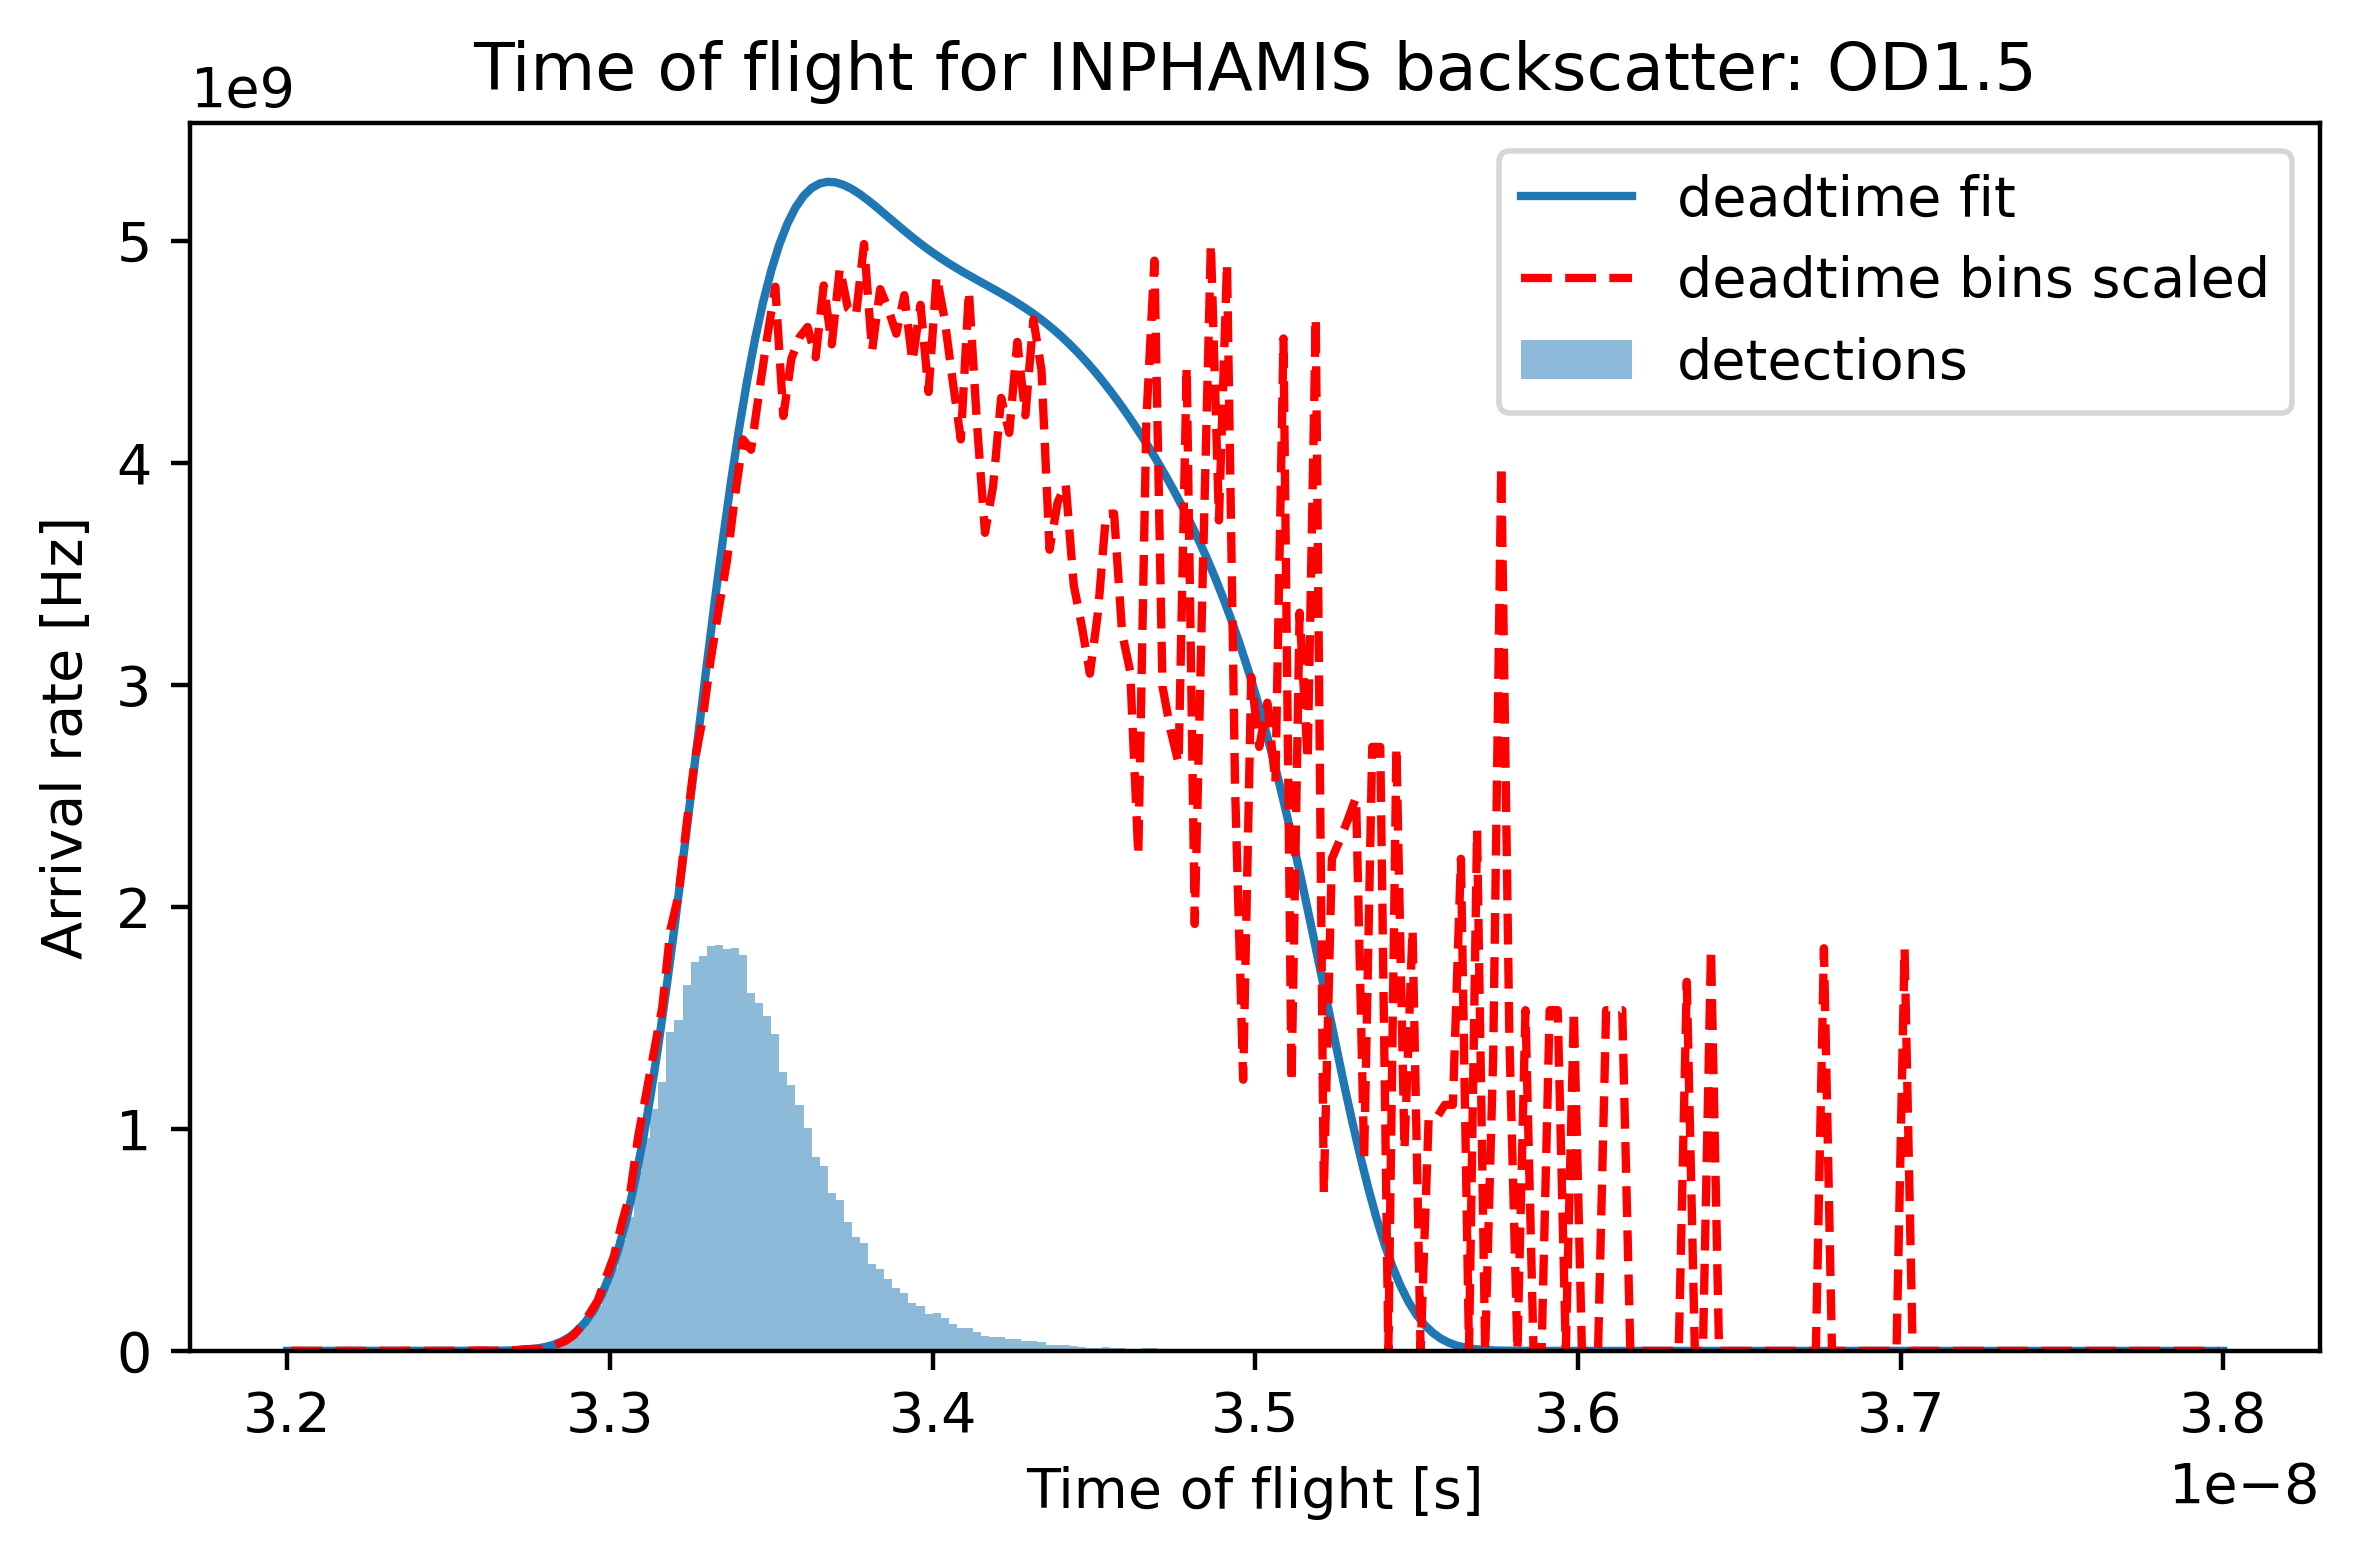

In [41]:
for i in range(len(OD_lst)):
    fit_dead = df_dead_fit['OD'+str(OD_lst[i])]
    H_I = active_ratio_hst_lst[i][:-1].numpy().T[0]
    ### Histogram of time of flight ###
    fig = plt.figure(dpi=400)
    ax = fig.add_subplot(111)
    ax.plot(t_fine, fit_dead, label='deadtime fit')
    
    flight_time = flight_time_lst[i]
    bin_array = set_binwidth(t_min, t_max, dt)
    n, bins = np.histogram(flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    N = n / binwidth / n_shots  # [Hz]
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, alpha=0.5, label='detections')
    ax.plot(center, N/H_I, 'r--', label='deadtime bins scaled')
    ax.set_xlabel('Time of flight [s]')
    ax.set_ylabel('Arrival rate [Hz]')
    ax.set_title('Time of flight for INPHAMIS backscatter: OD{}'.format(OD_lst[i]))
    plt.tight_layout()
    plt.legend()

    save_name = r'\OD{}.png'.format(OD_lst[i])
    plt.savefig(save_loc+save_name)
    plt.show()